# A toy default risk model

## Dataset

In [28]:
#your name:
#your student number:


import numpy as np

num_samples = 100000

# draw random numbers for every feature
x_1 = np.random.uniform(low=18., high=80., size=(num_samples, 1))               #age
x_2 = np.random.uniform(low=1., high=15., size=(num_samples, 1))                #income (thousands)
x_3 = np.float32(np.random.uniform(low=0., high=1., size=(num_samples, 1)) < .1)#self-employed or employed 

X = np.concatenate([x_1, x_2, x_3], axis=1)

sigmoid = lambda x: 1. / (1. + np.exp(-x))


# a linear model
b_0 = -13.3
b_1 = .33
b_2 = -3.5
b_3 = 3.

p_1 = sigmoid(b_0 + b_1 * x_1 + b_2 * x_2 + b_3 * x_3)
y_1 = np.float32(np.squeeze(np.random.uniform(size=(num_samples, 1)) < p_1))


# a non-linear model 
b_0 = -5.
b_1 = 10.
b_2 = -1.1
b_3 = 1.
# Briefly comment on the case b_1 = b_2 = b_3 = 0 here:
# todo

p_2 = sigmoid(b_0 + b_1 * ((x_1 < 25.) + (x_1 > 75.)) + b_2 * x_2 + b_3 * x_3)
y_2 = np.float32(np.squeeze(np.random.uniform(size=(num_samples, 1)) < p_2))


# divide dataset into train- and testset
X_train_1 = X_train_2 = X[:80000, :]
X_test_1 = X_test_2 = X[80000:, :]
y_train_1 = y_1[:80000]
y_test_1 = y_1[80000:]
y_train_2 = y_2[:80000]
y_test_2 = y_2[80000:]
p_2_test = p_2[80000:, :]


# check if we have around 5% defaults on the whole dataset in for each model
print("Linear model: default rate {:.2f}%".format(np.mean(p_1) * 100.))
print("Non-linear model: default rate {:.2f}%".format(np.mean(p_2) * 100.))


Linear model: default rate 5.08%
Non-linear model: default rate 5.11%


## Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression

#logitic regression for the linear dataset
model_LR_1 = LogisticRegression().fit(X_train_1, y_train_1)

#a look at the coefficients
print(model_LR_1.coef_)
print(model_LR_1.intercept_)

#logitic regression for the non-linear dataset
model_LR_2 = LogisticRegression().fit(X_train_2, y_train_2)

print(model_LR_2.coef_)
print(model_LR_2.intercept_)

[[ 0.32021005 -3.3985065   2.98838565]]
[-12.90031078]
[[-0.01360843 -0.49576104  0.33427451]]
[0.21717939]


### Roc curves for the logistic regression

total deviance for training data = 0.03287528057288603
total deviance for test data = 0.033245366090479615


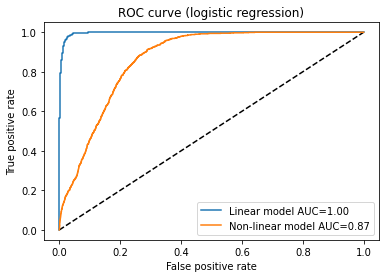

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss

#calculate the scores on the linear testset
scores_LR_1_train = model_LR_1.predict_proba(X_train_1)
scores_LR_1 = model_LR_1.predict_proba(X_test_1)
#calculate fpr and tpr
fpr_LR_1, tpr_LR_1, thresholds_LR_1 = metrics.roc_curve(y_test_1, scores_LR_1[:, 1], pos_label=1)
#calculate auc
auc_LR_1 = roc_auc_score(y_test_1, scores_LR_1[:, 1])
#calculate total deviance for training and test data. 
#Note that scores_LR_1_train[:, 1] is the predicted default probability
print('total deviance for training data = ' + str(log_loss(y_train_1, scores_LR_1_train[:, 1])))
print('total deviance for test data = ' + str(log_loss(y_test_1, scores_LR_1[:, 1])))

#calculate the scores on the non-linear testset
scores_LR_2 = model_LR_2.predict_proba(X_test_2)
fpr_LR_2, tpr_LR_2, thresholds_LR_2 = metrics.roc_curve(y_test_2, scores_LR_2[:, 1], pos_label=1)
auc_LR_2 = roc_auc_score(y_test_2, scores_LR_2[:, 1])
#calculate total deviance for training and test data:
#todo

#plot the roc curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LR_1, tpr_LR_1, label='Linear model AUC={:.2f}'.format(auc_LR_1))
plt.plot(fpr_LR_2, tpr_LR_2, label='Non-linear model AUC={:.2f}'.format(auc_LR_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (logistic regression)')
plt.legend(loc='best')


## Neural networks

In [31]:
import tensorflow as tf
from tensorflow import keras 

#build the nn model with 2 hidden layers
model_NN = keras.Sequential(
    [
     keras.layers.BatchNormalization(),
     keras.layers.Dense(32, activation='relu', name="hidden_layer_1"),
     keras.layers.Dense(32, activation='relu', name="hidden_layer_2"),
     keras.layers.Dense(1, activation='sigmoid', name="output_layer")
    ]
)

#the loss function
def total_deviance(y_true, y_pred):
    return tf.math.reduce_mean(-y_true * tf.math.log(y_pred) - (1. - y_true) * tf.math.log(1. - y_pred))

#pick an optimizer
model_NN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=total_deviance
)

#shuffle the data during training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_2, np.float32(y_train_2)))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(256)

#fit the model
model_NN.fit(
    train_dataset,
    batch_size=256,
    epochs=10
)


Epoch 1/10
313/313 [==============================] - 2s 3ms/step - loss: 0.2164
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0994
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0763
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0709
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0695
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0685
Epoch 7/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0677
Epoch 8/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0674
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0661
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0658


### Roc curves for the neural network

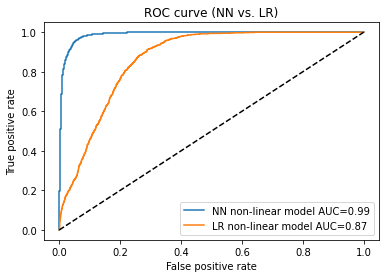

In [32]:

#calculate the scores on the testdata
scores_NN_train = model_NN(X_train_2)
scores_NN = model_NN(X_test_2)
fpr_NN, tpr_NN, thresholds_NN = metrics.roc_curve(y_test_2, scores_NN[:, 0], pos_label=1)
auc_NN = roc_auc_score(y_test_2, scores_NN[:, 0])

#calculate total deviance for training and test data.
#Note that scores_NN[:, 0] is the predicted default probability.
#todo

plt.plot(fpr_NN, tpr_NN, label='NN non-linear model AUC={:.2f}'.format(auc_NN))
plt.plot(fpr_LR_2, tpr_LR_2, label='LR non-linear model AUC={:.2f}'.format(auc_LR_2))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (NN vs. LR)')
plt.legend(loc='best')


## P&L Analysis

Mean: 3958.09
VaR: 16180.00
Mean (LR): 2688.40
VaR (LR): 9050.00
Mean (NN): 37481.21
VaR (NN): -30880.00


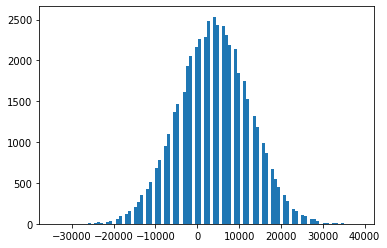

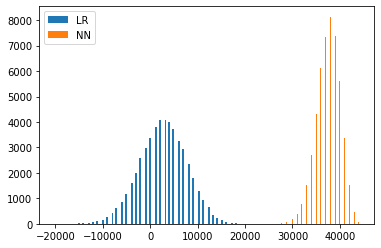

In [33]:
from scipy.stats import norm
import matplotlib as mpl

portfolio_size = 5000
loan_amount = 1000. 
rate = 0.055

#simulate the defaults on the loan portfolio
defaults = np.float32(np.random.uniform(low=0., high=1., size=(portfolio_size, 50000)) < p_2_test[:portfolio_size, :])


#p&l for scenario 1
p_and_l_a = np.sum(loan_amount * (rate * (1. - defaults) - defaults), axis=0)

#histogramm for scenario 1
plt.figure(1)
plt.hist(p_and_l_a, bins=100)

print('Mean: {:.2f}'.format(np.mean(p_and_l_a)))
p_and_l_a = np.sort(p_and_l_a)
print('VaR: {:.2f}'.format(-p_and_l_a[499]))

#scenario 2

rate = 0.01

p_and_l_b_LR = np.sum(loan_amount * (rate * (1. - defaults) - defaults) * np.float32(scores_LR_2[:portfolio_size, 1:2] < 0.05), axis=0)
p_and_l_b_NN = np.sum(loan_amount * (rate * (1. - defaults) - defaults) * np.float32(scores_NN[:portfolio_size, :] < 0.05), axis=0)


plt.figure(2)
plt.hist(p_and_l_b_LR, bins=100, label='LR')
plt.hist(p_and_l_b_NN, bins=100, label='NN')
plt.legend()


print('Mean (LR): {:.2f}'.format(np.mean(p_and_l_b_LR)))
p_and_l_b_LR = np.sort(p_and_l_b_LR)
print('VaR (LR): {:.2f}'.format(-p_and_l_b_LR[499]))

print('Mean (NN): {:.2f}'.format(np.mean(p_and_l_b_NN)))
p_and_l_b_NN = np.sort(p_and_l_b_NN)
print('VaR (NN): {:.2f}'.format(-p_and_l_b_NN[499]))

